In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from typing import Dict, Tuple, List, Union, Any
from pathlib import Path
from jsonlines import jsonlines

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from transformers import AutoModel, AutoTokenizer
from transformers import logging

from src.settings import EMBEDDINGS_DIR

tqdm.pandas()
logging.set_verbosity_error()

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print(f"{DEVICE=}")

torch.cuda.empty_cache()

DEVICE=device(type='cuda', index=0)


## Dataset

In [3]:
train_df = pd.read_feather(EMBEDDINGS_DIR / "train_df_herbert_pl_task_clf.feather").drop(columns="target")  #.sample(frac=0.3)
val_df = pd.read_feather(EMBEDDINGS_DIR / "val_df_herbert_pl_task_clf.feather").drop(columns="target")  #.sample(frac=0.3)

In [4]:
train_df.shape, val_df.shape, val_df.shape[0] / train_df.shape[0]

((32284, 3), (8071, 3), 0.25)

In [5]:
id2label = {i: label for i, label in enumerate(sorted(pd.concat([train_df["task_label"], val_df["task_label"]]).unique()))}
label2id = {label: i for i, label in id2label.items()}

id2label

{0: '13', 1: '15', 2: '17', 3: '24', 4: '7', 5: '8'}

In [6]:
train_df["task_id"] = train_df["task_label"].map(label2id)
val_df["task_id"] = val_df["task_label"].map(label2id)

In [7]:
test_df, val_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df["task_label"])

In [8]:
train_df

,text,task_label,embedding,task_id
13501,"A on nic nie pamiętał, bo spał nieprzytomny.",24,"[0.18977925, 0.012815773, -0.28480715, 0.99845...",3
4389,"Wiatrak, szkielet, ucieczka.",15,"[-0.17135437, 0.1266071, 0.060243882, 0.997987...",1
23428,"Podzielił się z kolegami, po jednej gruszce dl...",17,"[-0.18515885, -0.20572688, -0.16450542, 0.9976...",2
25049,Odszedł.,17,"[-0.19777678, -0.15496688, -0.07709964, 0.9993...",2
39380,"No, OK.",13,"[-0.04938157, -0.076477386, -0.10442537, 0.999...",0
...,...,...,...,...
27880,"Policjant stoi za nim, od bierze zamach i doty...",17,"[-0.03060891, 0.10742664, -0.20071696, 0.99724...",2
36144,Uchwyt-harmonijka.,13,"[-0.18037312, 0.0025283194, -0.07515499, 0.999...",0
24741,Nadeszło trzech chłopców.,17,"[-0.10670652, -0.113593616, -0.118542075, 0.99...",2
36946,Za drzwiami jest głośno.,13,"[0.046075575, 0.058143564, -0.19632398, 0.9988...",0


In [9]:
from numpy import add


class OrkpjmTaskDataset(Dataset):

    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.len = df.shape[0]
        self.texts = df["text"].to_numpy()
        self.labels = df["task_id"].to_numpy()

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        encoded_and_prep_text = self._get_encoded_and_prep_text(self.texts[index])
        return {
            "input_ids": torch.tensor(encoded_and_prep_text['input_ids']),
            "attention_mask": torch.tensor(encoded_and_prep_text['attention_mask']),
            "label": torch.tensor(self.labels[index])
        }

    def _get_encoded_and_prep_text(self, text: str,  max_length: int = 50, padding: str = 'max_length', truncation: bool = True) -> Dict[str, torch.Tensor]:
        return self.tokenizer.encode_plus(
            text,
            max_length=max_length,
            padding=padding,
            truncation=truncation,
            add_special_tokens=True,
            # return_tensors='pt',
        )


In [10]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
# tokenizer = AutoTokenizer.from_pretrained("dkleczek/bert-base-polish-cased-v1")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# tokenizer.pad_token_id = 0

In [11]:
train_ds = OrkpjmTaskDataset(train_df, tokenizer=tokenizer)
val_ds = OrkpjmTaskDataset(val_df, tokenizer=tokenizer)
test_ds = OrkpjmTaskDataset(test_df, tokenizer=tokenizer)

In [12]:
EMBEDDINGS_DIM = 768
BATCH_SIZE = 32
NUM_LABELS = 6

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, pin_memory=True)

In [13]:
for batch in train_dl:
    print(batch["input_ids"].shape)
    print(batch["attention_mask"].shape)
    print(batch["label"].shape)
    # assert batch["embedding"].shape[1] == EMBEDDINGS_DIM
    # assert batch["embedding"].shape[0] == batch["target"].shape[0]
    break

torch.Size([32, 50])
torch.Size([32, 50])
torch.Size([32])


## Simple NN

In [14]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_labels, hidden_dim=128):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()
        self.output = nn.Linear(hidden_dim, num_labels)

    def forward(self, x):
        x = self.hidden(x)
        x = self.act(x)
        x = self.output(x)
        return x


## Transformers

In [15]:
class PretrainedArch(nn.Module):

    def __init__(self, pretrained_model, num_labels, freeze_pretrained=True):
        super(PretrainedArch, self).__init__()
        self.pretrained_model = pretrained_model
        if freeze_pretrained:
            self._freeze_pretrained()
        self.dropout = nn.Dropout(0.1)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, num_labels)
        self.softmax = nn.LogSoftmax(dim=1)

    def _freeze_pretrained(self):
        for param in self.pretrained_model.parameters():
            param.requires_grad = False

    def forward(self, sent_id, mask):
        # print(sent_id.shape, mask.shape)
        pretrained_output = self.pretrained_model(sent_id, attention_mask=mask, return_dict=True)
        x = self.fc1(pretrained_output.pooler_output if hasattr(pretrained_output, 'pooler_output') else pretrained_output.last_hidden_state[:, 0, :])
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [16]:
def train_step(model, optimizer, loss_fn, train_dl, device="cuda", norm_grad=True):
    # one epoch training
    model.train()
    total_loss, total_accuracy = 0, 0

    train_dl_len = len(train_dl)
    total_preds = []  # przygotowanie listy do przechowywania predykcji modelu
    for step, batch in enumerate(train_dl):
        # if step % 50 == 0 and not step == 0:
        #     print(f'  Batch {step:>5,}  of  {train_dl_len:>5,}.')

        batch = {k: v.to(device) for k, v in batch.items()}

        model.zero_grad()
        preds = model(batch["input_ids"], batch["attention_mask"])
        loss = loss_fn(preds, batch["label"])
        total_loss = total_loss + loss.item()
        loss.backward()

        if norm_grad:
            # Normalizacja wartości gradientów
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        preds = preds.detach().cpu().numpy()

    total_preds.append(preds)
    avg_loss = total_loss / train_dl_len

    # Predykcje modelu mają wymiary (liczba pakietów, rozmiar pakietu, liczba klas).
    # Przekształcenie ich do wymiarów (liczba próbek, liczba klas)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


def evaluate_step(model, loss_fn, val_dl, device="cuda"):
    # one epoch evaluation
    val_dl_len = len(val_dl)
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    for step, batch in enumerate(val_dl):
        # if step % 50 == 0 and not step == 0:
        #     print(f'  Batch {step:>5,}  of  {val_dl_len:>5,}.')

        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            preds = model(batch["input_ids"], batch["attention_mask"])
            loss = loss_fn(preds, batch["label"])
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / val_dl_len
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


def test(model, test_dl, device="cuda") -> Tuple[np.ndarray, Dict[str, Dict[str, float]]]:
    all_preds, all_test_y = [], []
    with torch.no_grad():
        for batch in test_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            preds = model(batch["input_ids"], batch["attention_mask"])

            preds = preds.detach().cpu().numpy()

            preds = np.argmax(preds, axis=1).flatten()
            all_preds.extend(preds)

            test_y = batch["label"].cpu().numpy().flatten()
            all_test_y.extend(test_y)

    return confusion_matrix(all_test_y, all_preds), classification_report(all_test_y, all_preds, output_dict=True, zero_division=0)

In [17]:
class_weights = compute_class_weight('balanced', classes=train_df["task_label"].unique(), y=train_df["task_label"].to_numpy())

In [18]:
EPOCHS = 5
LR = 1e-3

pretrained_checkpoint = "bert-base-uncased"

model = PretrainedArch(
    pretrained_model=AutoModel.from_pretrained(pretrained_checkpoint),
    num_labels=NUM_LABELS,
    freeze_pretrained=False
).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)

loss_fn = nn.NLLLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(DEVICE))


exp_results = []
for epoch in tqdm(range(EPOCHS)):
    train_loss, _ = train_step(model, optimizer, loss_fn, train_dl, device=DEVICE)
    valid_loss, _ = evaluate_step(model, loss_fn, val_dl, device=DEVICE)
    test_cm, test_clf_report = test(model, test_dl, device=DEVICE)

    exp_results.append({
        "PretrainedModelName": pretrained_checkpoint,
        "Epoch": epoch + 1,
        "LearningRate": LR,
        "BatchSize": BATCH_SIZE,
        "TrainLoss": train_loss,
        "ValLoss": valid_loss,
        "TestConfMatrix": test_cm.tolist(),
        "TestClfReport": test_clf_report,
    })

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
exp_results_df = pd.DataFrame.from_records(exp_results)
exp_results_df["TestMacroAvgF1"] = exp_results_df.TestClfReport.apply(lambda x: x["macro avg"]["f1-score"])
exp_results_df

,PretrainedModelName,Epoch,LearningRate,BatchSize,TrainLoss,ValLoss,TestConfMatrix,TestClfReport,TestMacroAvgF1
0,bert-base-uncased,1,0.001,32,1.719532,1.695875,"[[498, 0, 0, 0, 0, 0], [1205, 0, 0, 0, 0, 0], ...","{'0': {'precision': 0.12342007434944238, 'reca...",0.03662
1,bert-base-uncased,2,0.001,32,1.698128,1.696098,"[[498, 0, 0, 0, 0, 0], [1205, 0, 0, 0, 0, 0], ...","{'0': {'precision': 0.12342007434944238, 'reca...",0.03662
2,bert-base-uncased,3,0.001,32,1.697494,1.695690,"[[498, 0, 0, 0, 0, 0], [1205, 0, 0, 0, 0, 0], ...","{'0': {'precision': 0.12342007434944238, 'reca...",0.03662
3,bert-base-uncased,4,0.001,32,1.699562,1.696005,"[[498, 0, 0, 0, 0, 0], [1205, 0, 0, 0, 0, 0], ...","{'0': {'precision': 0.12342007434944238, 'reca...",0.03662
4,bert-base-uncased,5,0.001,32,1.697255,1.695479,"[[498, 0, 0, 0, 0, 0], [1205, 0, 0, 0, 0, 0], ...","{'0': {'precision': 0.12342007434944238, 'reca...",0.03662


<Axes: >

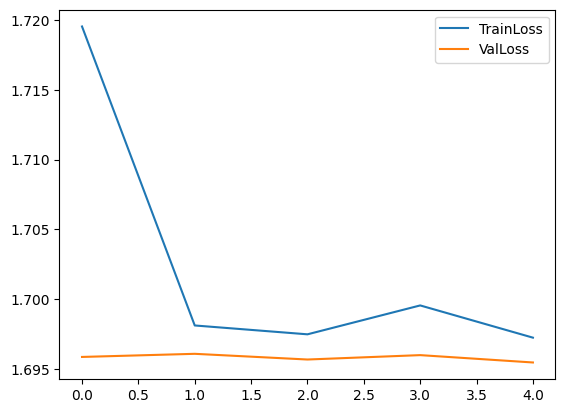

In [20]:
exp_results_df[["TrainLoss", "ValLoss"]].plot()

<Axes: >

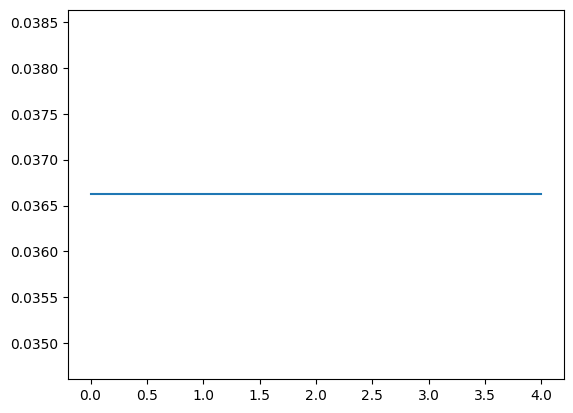

In [21]:
exp_results_df.TestMacroAvgF1.plot()

In [22]:
assert False

AssertionError: 

In [ ]:
simple_nn_history_df = pd.DataFrame.from_records(simple_nn_history)
simple_nn_history_df

In [ ]:
simple_nn_history_df[["TrainLoss", "ValLoss"]].plot()

In [ ]:
simple_nn_history_df.ValAcc.plot()